In [15]:
using Gmsh
using Gridap
using GridapGmsh
using LinearAlgebra
using Plots
using DifferentialEquations

Import the Mesh to a model and get the nodes and elements

In [16]:
model = GmshDiscreteModel("../data/VenturaAccelerometer/test_mesh_v2.msh")
nodes = model.grid.node_coordinates



Info    : Reading '../data/VenturaAccelerometer/test_mesh_v2.msh'...
Info    : 1 entity
Info    : 8 nodes
Info    : 6 elements
Info    : Done reading '../data/VenturaAccelerometer/test_mesh_v2.msh'


8-element Vector{VectorValue{2, Float64}}:
 VectorValue{2, Float64}(-1.0, 0.5)
  VectorValue{2, Float64}(0.0, 1.0)
 VectorValue{2, Float64}(-1.0, 1.0)
 VectorValue{2, Float64}(-1.0, 0.0)
  VectorValue{2, Float64}(0.0, 0.0)
  VectorValue{2, Float64}(1.0, 0.0)
  VectorValue{2, Float64}(1.0, 0.5)
  VectorValue{2, Float64}(1.0, 1.0)

In [17]:
elements = model.grid.cell_node_ids

6-element Gridap.Arrays.Table{Int32, Vector{Int32}, Vector{Int32}}:
 [1, 2, 3]
 [1, 4, 5]
 [5, 6, 7]
 [1, 2, 5]
 [2, 5, 7]
 [2, 7, 8]

Get all the areas of the elements

In [18]:
Areas = zeros(length(elements))
A = 0
for (i, element) in enumerate(elements)
    area = 0
    for j in 1:length(element)
        k = j % length(element) + 1
        area += nodes[element[j]][1] * nodes[element[k]][2] - nodes[element[j]][2] * nodes[element[k]][1]
    end 
    Areas[i] = abs(area)/2  

end
println(Areas)
println(sum(Areas))
println(length)


[0.25, 0.25, 0.25, 0.5, 0.5, 0.25]
2.0
length


Define the F funtion

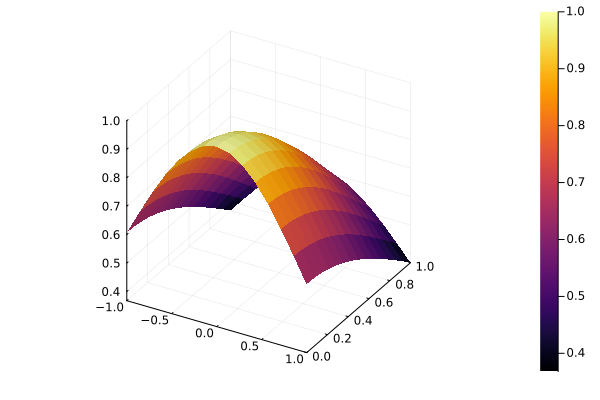

In [19]:
function load(x, y, t)
    x0 = 0.0
    y0 = 0.0
    sigmax = 1
    sigmay = 1
    return exp(-(((x-x0)^2)/(2*sigmax^2) + (y-y0)^2/(2*sigmay^2)))
    # return float(x == 0 && y == 0)
end

# matlab: meshgrid function:
function meshgrid(xin,yin)
    nx=length(xin)
    ny=length(yin)
    xout=zeros(ny,nx)
    yout=zeros(ny,nx)
    for jx=1:nx
        for ix=1:ny
            xout[ix,jx]=xin[jx]
            yout[ix,jx]=yin[ix]
        end
    end
    return (x=xout, y=yout)
end

# Plotting the load:
x = LinRange(-1,1,15)
y = LinRange(0, 1,15)
X,Y  = meshgrid(x,y)
fvalues = load.(X, Y, 0)

surface(X,Y,fvalues)


Compute the K matrix FINALLY

In [20]:
N = length(nodes)
Ke = zeros(3,3)
K = zeros(N,N)
F = zeros(N)
for (index,element) in enumerate(elements)
    COORDS = []
    for nd in element
        xi, yi= nodes[nd]
        COORDS = vcat(COORDS, [xi, yi, 1])
    end
    COORDS = transpose(reshape(COORDS, 3, 3))
    ABC = inv(float.(COORDS))

    for i in 1:3
        for j in 1:3
            Ke[i,j] = ABC[1,i]*ABC[1,j] + ABC[2, i]*ABC[2, j]
        end
    end

    Ke = Ke * Areas[index]

    for (local_i, real_i) in enumerate(element)
        for (local_j, real_j) in enumerate(element)
            K[real_i, real_j]+= Ke[local_i, local_j]
        end
    end

    # F, LOAD VECTOR
    for (local_i, global_i) in enumerate(element)
        fe = zeros(3)
        for (k,nd) in enumerate(element)
            xi,yi = nodes[nd]
            fe[k] = load(xi, yi, 0)
        end
        F[global_i] += fe[local_i] * Areas[index]/3
    end

end

display(K)
display(F)
# println(Areas[(2)])
# println(Areas[(3)])

8×8 Matrix{Float64}:
  2.5   -0.25  -1.0   -1.0   -0.25   0.0    0.0    0.0
 -0.25   1.75  -0.25   0.0   -0.75   0.0   -0.25  -0.25
 -1.0   -0.25   1.25   0.0    0.0    0.0    0.0    0.0
 -1.0    0.0    0.0    1.25  -0.25   0.0    0.0    0.0
 -0.25  -0.75   0.0   -0.25   1.75  -0.25  -0.25   0.0
  0.0    0.0    0.0    0.0   -0.25   1.25  -1.0    0.0
  0.0   -0.25   0.0    0.0   -0.25  -1.0    2.5   -1.0
  0.0   -0.25   0.0    0.0    0.0    0.0   -1.0    1.25

8-element Vector{Float64}:
 0.17842047617299675
 0.3032653298563167
 0.030656620097620196
 0.050544221642719454
 0.5
 0.050544221642719454
 0.17842047617299675
 0.030656620097620196

#### Reduced Stiffness Matrix and Load Vector with Boundary Conditions

Let:

- ``BC_nodes``:vector with the local numbering of the nodes that have Dirichlet boundary conditions.

- ``BC_values``: vector of the values of the actual boundary conditions.

In [21]:
# Example that clamps the short edges of the plate, global nodes numbers: [1,3,4,6,7,8]

# BC_nodes  = [1,3,4,6,7,8]
# BC_values = [0,0,0,0,0,0]

BC_nodes  = [1]
BC_values = [0]

for i in 1:N
    if i in BC_nodes
        K[i,:] = zeros(N)
        K[i,i] = 1
        index = findfirst.(isequal.(i), (BC_nodes,))
        F[i] = BC_values[Int(index[1])]
    end
end
display(K)
display(F)

8×8 Matrix{Float64}:
  1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0
 -0.25   1.75  -0.25   0.0   -0.75   0.0   -0.25  -0.25
 -1.0   -0.25   1.25   0.0    0.0    0.0    0.0    0.0
 -1.0    0.0    0.0    1.25  -0.25   0.0    0.0    0.0
 -0.25  -0.75   0.0   -0.25   1.75  -0.25  -0.25   0.0
  0.0    0.0    0.0    0.0   -0.25   1.25  -1.0    0.0
  0.0   -0.25   0.0    0.0   -0.25  -1.0    2.5   -1.0
  0.0   -0.25   0.0    0.0    0.0    0.0   -1.0    1.25

8-element Vector{Float64}:
 0.0
 0.3032653298563167
 0.030656620097620196
 0.050544221642719454
 0.5
 0.050544221642719454
 0.17842047617299675
 0.030656620097620196

#### First time dependent approximation `K*c = F(x,y,t)`

In [22]:
# Time parameters
t0 = 0
dt = 0.1
tf = 1
times = Vector(t0:dt:tf)
# Array with the solution: rows are the components, columns are timesteps
U = zeros(N,length(times))

for (t_index,t) in enumerate(times)
    # Defining the F vector for each time step:
    for (e_index,element) in enumerate(elements)
        for (local_i, global_i) in enumerate(element)
            fe = zeros(3)
            for (k,nd) in enumerate(element)
                xi,yi = nodes[nd]
                fe[k] = load(xi, yi, 0)
            end
            F[global_i] += fe[local_i] * Areas[e_index]/3
        end
    end
    # Reducing the F vector for each timestep (K is already reduced):
    for i in 1:N
        if i in BC_nodes
            bc_index = findfirst.(isequal.(i), (BC_nodes,))
            F[i] = BC_values[Int(bc_index[1])]
        end
    end

    c = K\F

end


## Simple `K*c=F` solution and plot

In [23]:
c = K\F

8-element Vector{Float64}:
  0.0
 13.876633271331977
  3.069630207203549
  3.4652408927982252
 14.90008182514059
 17.57199252675012
 17.633439542439863
 17.176381841155436

In [24]:
function get_XY_nodes(nodes)
    N = size(nodes)[1]
    X = zeros(N)
    Y = zeros(N)
    for k in 1:N    
        X[k], Y[k] = nodes[k]
    end
    return X,Y
end
xvec, yvec = get_XY_nodes(nodes)
print("Done")

Done

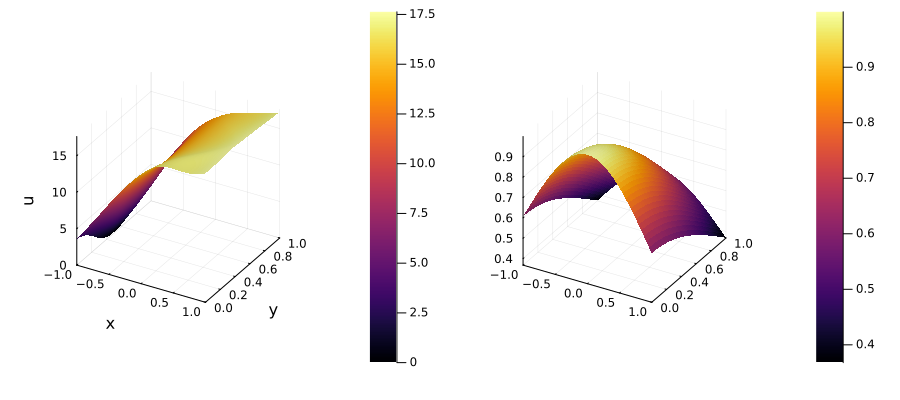

In [25]:
p1 = surface(xvec,yvec,c,st=:surface)
xlabel!("x")
ylabel!("y")
zlabel!("u")

x = LinRange(-1,1,50)
y = LinRange(0, 1,50)
X,Y  = meshgrid(x,y)
fvalues = load.(X, Y, 0)
p2 = surface(X,Y,fvalues)
plot(p1,p2, layout=(1,2), size=(900,400))


# TIME DEPENDENT PROBLEM

Create de M matrix

In [26]:
M = zeros(N,N)
for (index,element) in enumerate(elements)
    Me = I(3)
    Me = Me*Areas[index]/3
    #display(Me)
    for (local_i, real_i) in enumerate(element)
        M[real_i, real_i]+= Me[local_i, local_i]
    end
end
display(M)

8×8 Matrix{Float64}:
 0.333333  0.0  0.0        0.0        0.0  0.0        0.0       0.0
 0.0       0.5  0.0        0.0        0.0  0.0        0.0       0.0
 0.0       0.0  0.0833333  0.0        0.0  0.0        0.0       0.0
 0.0       0.0  0.0        0.0833333  0.0  0.0        0.0       0.0
 0.0       0.0  0.0        0.0        0.5  0.0        0.0       0.0
 0.0       0.0  0.0        0.0        0.0  0.0833333  0.0       0.0
 0.0       0.0  0.0        0.0        0.0  0.0        0.333333  0.0
 0.0       0.0  0.0        0.0        0.0  0.0        0.0       0.0833333

Damping Matrix

In [27]:
alpha = 0.1
beta  = 0.0
C = alpha * M + beta * K
display(C)

8×8 Matrix{Float64}:
 0.0333333  0.0   0.0         …  0.0         0.0        0.0
 0.0        0.05  0.0            0.0         0.0        0.0
 0.0        0.0   0.00833333     0.0         0.0        0.0
 0.0        0.0   0.0            0.0         0.0        0.0
 0.0        0.0   0.0            0.0         0.0        0.0
 0.0        0.0   0.0         …  0.00833333  0.0        0.0
 0.0        0.0   0.0            0.0         0.0333333  0.0
 0.0        0.0   0.0            0.0         0.0        0.00833333

[10.169967141860816, 11.524082534540035, 6.989709382257404, 11.524082534540035, 19.0, 11.524082534540035, 10.169967141860816, 6.989709382257404]
ArrayPartition

{Float64, Tuple{Vector{Float64}, Vector{Float64}}}(([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]))


┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1


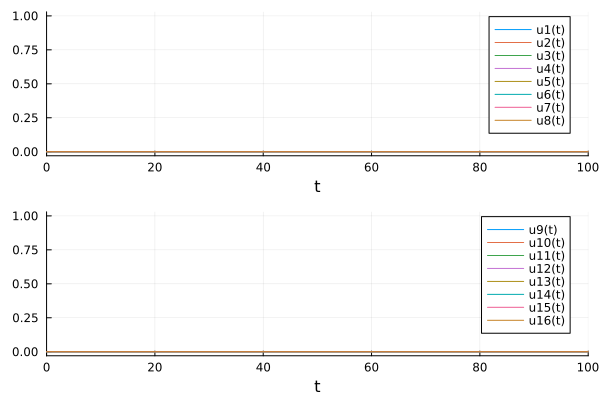

In [35]:
function load(x, y, t)
    x0 = 0.0
    y0 = 0.0
    sigmax = 1
    sigmay = 1
    return exp(-(((x-x0)^2)/(2*sigmax^2) + (y-y0)^2/(2*sigmay^2)))*(20-t)
    # return float(x == 0 && y == 0)
end

function bigF(t)
    # xvec, yvec; were the vectors with the coordinates of the nodes
    bigD = zeros(N)
    for k in 1:N
        bigD[k] = load(xvec[k],yvec[k],t)
    end
    return bigD
end

println(bigF(1))

#..define the right-hand side of the ordinary differential equation of the equation of motion 
function CompleteProblem!(ddu,du,u,p,t)
    # ddu .= (-K*u .-C.*du + F)#.*inv(M)
    ddu = inv(M) * (bigF(t) - K*u - C*du)
end

#..set initial position and velocity
u0 = fill(0.,N)
# u0[8] = .2

v0 = zeros(N)
                                    
#..set time begin and end forward
tspan = (0.0,100.0)           

#..define ODE problem to be solved  
prob = SecondOrderODEProblem(CompleteProblem!,v0,u0,tspan)

#..solve ODE problem 
sol = DifferentialEquations.solve(prob)

println(sol(1))

#..plot the source term
tvec = Vector(0.:0.01:10.)
#fvec = f.(tvec)
# p1 = plot(tvec,fvec,label="Excitation")


#..velocity and position have vars=(1,2) and vars=(3,4), respectively. 
plot(sol,vars=1)
for i in 2:N-1
    plot!(sol,vars=i)
end
p1 = plot!(sol,vars=N)

plot(sol,vars=N+1)
for i in N+2:2*N-1
    plot!(sol,vars=i)
end
p2 = plot!(sol,vars=2*N)


#..plot solution of velocity and position as function of time  
plot(p1,p2,layout=(2,1))
